# Network 1

A module to implement the stochastic gradient descent learning algorithm for a feedforward neural network.  Gradients are calculated using backpropagation.

___

### Importing libraries

In [1]:
# Standard library
import random
import pickle
import gzip

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt

### Miscellaneous functions
#### The sigmoid function and its derivative.

$$ \sigma (z) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-z} }  $$ 
$$ \sigma ^{'} (z) =  \sigma (z) \times (1- \sigma (z))  $$ 

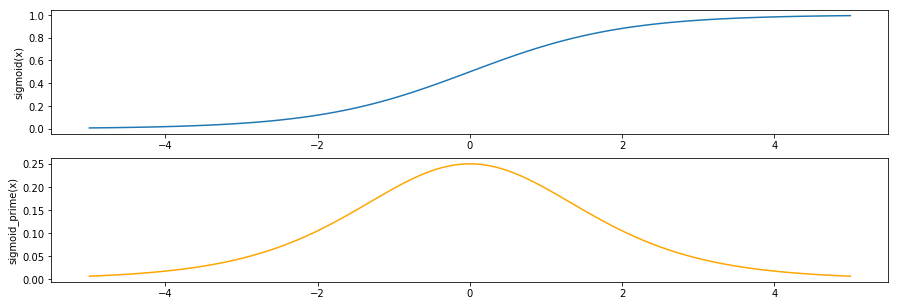

In [2]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

plt.rcParams['figure.figsize'] = 15, 5
plt.subplot(211);plt.plot(np.linspace(-5,5,100),sigmoid(np.linspace(-5,5,100)));plt.ylabel('sigmoid(x)')
plt.subplot(212);plt.plot(np.linspace(-5,5,100),sigmoid_prime(np.linspace(-5,5,100)),color='orange');plt.ylabel('sigmoid_prime(x)')
plt.show()

### Creating the Network class
> All the methods associated to the network will be added next

In [3]:
class Network(object):
    pass

### `__init__(self, sizes)`
The list `sizes` contains the number of neurons in the respective layers of the network.  For example, if the list was `[2, 3, 1]` then it would be a three-layer network, with the first layer containing 2 neurons, the second layer 3 neurons, and the third layer 1 neuron.  

$$
    sizes = [3, 4, 2]
    \rightarrow \begin{matrix} 
    \begin{matrix} ○ \\ ○ \\ ○  \end{matrix} 
    & \begin{matrix} ○  \\ ○ \\ ○ \\ ○  \end{matrix} 
    & \begin{matrix} ○  \\ ○  \end{matrix} 
    \end{matrix}
$$

The biases and weights for the network are initialized randomly, using a Gaussian distribution with mean 0, and variance 1.

$$
    num\_layers = 3
$$  
$$
    biases =
    \begin{bmatrix} 
    \begin{pmatrix} \cdot \\ \cdot \\ \cdot  \end{pmatrix},
    &\begin{pmatrix} \cdot  \\ \cdot \\ \cdot \\ \cdot  \end{pmatrix},
    &\begin{pmatrix} \cdot  \\ \cdot  \end{pmatrix} 
    \end{bmatrix}  
$$  
$$
    weights =
    \begin{bmatrix} 
        \begin{pmatrix} 
            \cdot & \cdot & \cdot 
            \\ \cdot & \cdot & \cdot
            \\ \cdot & \cdot & \cdot
            \\ \cdot & \cdot & \cdot
        \end{pmatrix},
        &\begin{pmatrix} 
            \cdot & \cdot & \cdot & \cdot  
            \\ \cdot & \cdot & \cdot & \cdot 
        \end{pmatrix}
    \end{bmatrix}
$$

> Note that the first layer is assumed to be an input layer, and by convention we won't set any biases for those neurons, since biases are only ever used in computing the outputs from later layers.

In [4]:
def __init__(self, sizes):
    self.num_layers = len(sizes)
    self.sizes = sizes
    self.biases = [np.random.randn(y, 1) for y in sizes[1:]] # [1:] => start at index 1, up to the end
    self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] # [:-1] => all elements of the sequence but the last
  
Network.__init__=__init__

### `feedforward(self, a)`
given an input a for the network, returns the corresponding output.
> It is assumed that the input a is an (n, 1) Numpy ndarray, not a (n,) vector. Here, n is the number of inputs to the network. If you try to use an (n,) vector as input you'll get strange results. Although using an (n,) vector appears the more natural choice, using an (n, 1) ndarray makes it particularly easy to modify the code to feedforward multiple inputs at once, and that is sometimes convenient.

In [5]:
def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

Network.feedforward=feedforward

### `SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None)`
Train the neural network using mini-batch stochastic gradient descent.

- The `training_data` is a list of tuples `(x, y)` representing the training inputs and the desired outputs. 
- The variables `epochs` and `mini_batch_size` are what you'd expect - the number of epochs to train for, and the size of the mini-batches to use when sampling.
- `eta` is the learning rate $ \eta $.
- If `test_data` is provided then the network will be evaluated against the test data after each epoch, and partial progress printed out.  This is useful for tracking progress, but slows things down substantially.

In each epoch, it starts by randomly shuffling the `training data`, and then partitions it into `mini-batches` of the appropriate size. This is an easy way of sampling randomly from the `training data`. Then for each `mini_batch` we apply a single step of gradient descent. This is done by the code `self.update_mini_batch(mini_batch, eta)`, which updates the network `weights` and `biases` according to a single iteration of gradient descent, using just the `training data` in `mini_batch`.

In [6]:
def SGD(self, training_data, epochs, mini_batch_size, eta,
    test_data=None):
    results = []
    training_data = list(training_data)
    n = len(training_data)

    if test_data:
        test_data = list(test_data)
        n_test = len(test_data)

    for j in range(epochs):
        random.shuffle(training_data)
        mini_batches = [
            training_data[k:k+mini_batch_size]
            for k in range(0, n, mini_batch_size)]
        for mini_batch in mini_batches:
            self.update_mini_batch(mini_batch, eta)
        if test_data:
            print("Epoch {} : {} / {}".format(j,self.evaluate(test_data),n_test));
        else:
            print("Epoch {} complete".format(j))
        results.append(self.evaluate(test_data))
    return results

Network.SGD=SGD

### `update_mini_batch(self, mini_batch, eta)`
Update the network's weights and biases by applying gradient descent using backpropagation to a single mini batch.
- The `mini_batch` is a list of tuples `(x, y)`
- `eta` is the learning rate.

This invokes something called the backpropagation algorithm, which is a fast way of computing the gradient of the cost function $ \nabla C$. So `update_mini_batch` works simply by computing these gradients for every training example in the `mini_batch`, and then updating `self.weights` and `self.biases` appropriately.

In [7]:
def update_mini_batch(self, mini_batch, eta):
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = self.backprop(x, y)
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    self.weights = [w-(eta/len(mini_batch))*nw
                    for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b-(eta/len(mini_batch))*nb
                   for b, nb in zip(self.biases, nabla_b)]
        
Network.update_mini_batch=update_mini_batch

### `backprop(self, x, y)`
Return a tuple `(nabla_b, nabla_w)` representing the gradient for the cost function C_x.

`nabla_b` and `nabla_w` are layer-by-layer lists of numpy arrays, similar to `self.biases` and `self.weights`.

In [8]:
def backprop(self, x, y):

    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(self.biases, self.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    # backward pass
    delta = self.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())
    # Note that the variable l in the loop below is used a little
    # differently to the notation in Chapter 2 of the book.  Here,
    # l = 1 means the last layer of neurons, l = 2 is the
    # second-last layer, and so on.  It's a renumbering of the
    # scheme in the book, used here to take advantage of the fact
    # that Python can use negative indices in lists.
    for l in range(2, self.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
    return (nabla_b, nabla_w)
    
Network.backprop=backprop

### `evaluate(self, test_data)`
Return the number of test inputs for which the neural network outputs the correct result. 

Note that the neural network's output is assumed to be the index of whichever neuron in the final layer has the highest activation.

In [9]:
def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
    
Network.evaluate=evaluate

### `cost_derivative(self, output_activations, y)`
Return the vector of partial derivatives \partial C_x / \partial a for the output activations.

In [10]:
def cost_derivative(self, output_activations, y):
        return (output_activations-y)
    
Network.cost_derivative=cost_derivative

___

# MNIST_loader

A library to load the MNIST image data.  For details of the data structures that are returned, see the doc strings for `load_data` and `load_data_wrapper`.  

In practice, `load_data_wrapper` is the function usually called by our neural network code.

___

### `Load_data()`

Return the MNIST data as a tuple containing the training data, the validation data, and the test data.

The ``training_data`` is returned as a tuple with two entries.

The first entry contains the actual training images.  This is a numpy ndarray with 50,000 entries.  Each entry is, in turn, a numpy ndarray with 784 values, representing the 28 * 28 = 784 pixels in a single MNIST image.

The second entry in the ``training_data`` tuple is a numpy ndarray containing 50,000 entries.  Those entries are just the digit values (0...9) for the corresponding images contained in the first entry of the tuple.

The ``validation_data`` and ``test_data`` are similar, except each contains only 10,000 images. 

This is a nice data format, but for use in neural networks it's helpful to modify the format of the ``training_data`` a little. That's done in the wrapper function ``load_data_wrapper()``, see below.

In [11]:
def load_data():
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

### `load_data_wrapper()`

Return a tuple containing ``(training_data, validation_data, test_data)``. Based on ``load_data``, but the format is more convenient for use in our implementation of neural networks. 

In particular, ``training_data`` is a list containing 50,000 2-tuples ``(x, y)``.  

``x`` is a 784-dimensional numpy.ndarray containing the input image.  

``y`` is a 10-dimensional numpy.ndarray representing the unit vector corresponding to the correct digit for ``x``. 

``validation_data`` and ``test_data`` are lists containing 10,000 2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional numpy.ndarry containing the input image, and ``y`` is the corresponding classification, i.e., the digit values (integers)corresponding to ``x``.

Obviously, this means we're using slightly different formats for the training data and the validation / test data.  These formats turn out to be the most convenient for use in our neural network code.

In [12]:
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

### `vectorized_result(j)`

Return a 10-dimensional unit vector with a 1.0 in the jth position and zeroes elsewhere.  This is used to convert a digit (0...9) into a corresponding desired output from the neural network.

In [13]:
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

___

# Testing the network

___

In [14]:
training_data, validation_data, test_data = load_data_wrapper()

In [15]:
net = Network([784, 30, 10])

In [16]:
results = net.SGD(training_data, 30, 10, 10, test_data=test_data)

print("\n",results)

Epoch 0 : 9079 / 10000
Epoch 1 : 9204 / 10000
Epoch 2 : 9217 / 10000
Epoch 3 : 9366 / 10000
Epoch 4 : 9346 / 10000
Epoch 5 : 9387 / 10000
Epoch 6 : 9367 / 10000
Epoch 7 : 9364 / 10000
Epoch 8 : 9356 / 10000
Epoch 9 : 9375 / 10000
Epoch 10 : 9383 / 10000
Epoch 11 : 9421 / 10000
Epoch 12 : 9395 / 10000
Epoch 13 : 9442 / 10000
Epoch 14 : 9445 / 10000
Epoch 15 : 9454 / 10000
Epoch 16 : 9313 / 10000
Epoch 17 : 9494 / 10000
Epoch 18 : 9465 / 10000
Epoch 19 : 9496 / 10000
Epoch 20 : 9497 / 10000
Epoch 21 : 9471 / 10000
Epoch 22 : 9393 / 10000
Epoch 23 : 9448 / 10000
Epoch 24 : 9462 / 10000
Epoch 25 : 9479 / 10000
Epoch 26 : 9501 / 10000
Epoch 27 : 9447 / 10000
Epoch 28 : 9475 / 10000
Epoch 29 : 9515 / 10000

 [9079, 9204, 9217, 9366, 9346, 9387, 9367, 9364, 9356, 9375, 9383, 9421, 9395, 9442, 9445, 9454, 9313, 9494, 9465, 9496, 9497, 9471, 9393, 9448, 9462, 9479, 9501, 9447, 9475, 9515]


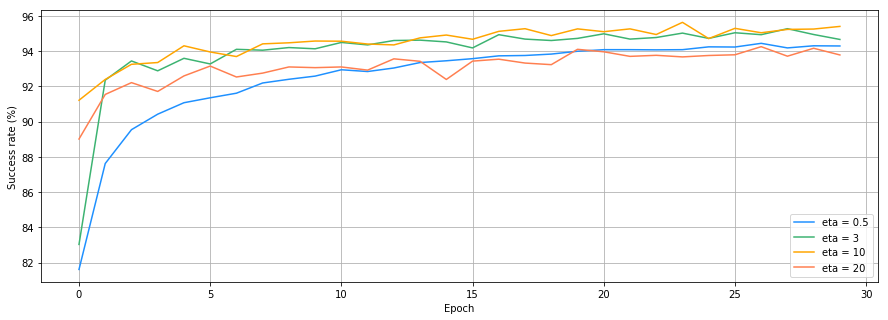

In [17]:
import matplotlib.pyplot as plt
# 0.5
results_1 = [8303, 9235, 9344, 9288, 9359, 9327, 9410, 9405, 9420, 9413, 9449, 9435, 9460, 9462, 9452, 9418, 9493, 9468, 9460, 9472, 9498, 9468, 9477, 9502, 9472, 9504, 9493, 9527, 9494, 9466]
# 3
results_2 = [8161, 8762, 8954, 9042, 9107, 9135, 9161, 9219, 9240, 9258, 9294, 9284, 9304, 9335, 9345, 9357, 9373, 9375, 9383, 9399, 9408, 9408, 9407, 9408, 9424, 9423, 9444, 9418, 9430, 9429]
# 10
results_3 = [9121, 9239, 9325, 9335, 9430, 9395, 9369, 9441, 9447, 9457, 9456, 9440, 9435, 9475, 9491, 9467, 9512, 9527, 9488, 9526, 9510, 9526, 9494, 9563, 9471, 9529, 9504, 9523, 9525, 9540]
# 20
results_4 = [8901, 9154, 9221, 9171, 9259, 9315, 9253, 9275, 9310, 9306, 9310, 9292, 9356, 9342, 9239, 9343, 9354, 9332, 9323, 9410, 9396, 9370, 9376, 9367, 9375, 9379, 9425, 9371, 9416, 9378]

def f(x):
    return ((x)/10000)*100

fig = plt.figure()
ax = fig.gca()
plt.plot(list(map(f,results_2)), color='dodgerblue', label='eta = 0.5')
plt.plot(list(map(f,results_1)), color='mediumseagreen', label='eta = 3')
plt.plot(list(map(f,results_3)), color='orange', label='eta = 10')
plt.plot(list(map(f,results_4)), color='coral', label='eta = 20')
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Success rate (%)")
plt.show()

